<a href="https://colab.research.google.com/github/sujeet107/Lung_Diseas_Detection/blob/main/LungDiseasDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
100% 2.02G/2.02G [00:31<00:00, 148MB/s]
100% 2.02G/2.02G [00:31<00:00, 69.2MB/s]


In [4]:
!unzip lungs-disease-dataset-4-types.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import layers

In [6]:
image_size = 150
labels = ['Corona Virus Disease', 'Normal', 'Tuberculosis', 'Pneumonia']
num_classes = len(labels)

def copy_dataset(src, dst):
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src, dst)

In [7]:
def merge_pneumonia_directories(base_path):
    pneumonia_dir = os.path.join(base_path, 'Pneumonia')
    os.makedirs(pneumonia_dir, exist_ok=True)
    viral_pneumonia_dir = os.path.join(base_path, 'Viral Pneumonia')
    bacterial_pneumonia_dir = os.path.join(base_path, 'Bacterial Pneumonia')
    for subdir in [viral_pneumonia_dir, bacterial_pneumonia_dir]:
        for filename in os.listdir(subdir):
            src_path = os.path.join(subdir, filename)
            dst_path = os.path.join(pneumonia_dir, filename)
            shutil.move(src_path, dst_path)
        os.rmdir(subdir)

In [8]:
original_dataset_path = '/content/Lung Disease Dataset'
writable_dataset_path = '/content/lungs-disease-dataset-4-types'
copy_dataset(original_dataset_path, writable_dataset_path)

# Merge directories in train, test, and val folders
base_paths = [
    os.path.join(writable_dataset_path, 'train'),
    os.path.join(writable_dataset_path, 'test'),
    os.path.join(writable_dataset_path, 'val')
]
for base_path in base_paths:
    merge_pneumonia_directories(base_path)

In [10]:
def load_and_balance_data(folder_path):
    X = []
    Y = []
    min_count = float('inf')

    # Count the number of images in each class
    for label in labels:
        folderPath = os.path.join(folder_path, label)
        count = len(os.listdir(folderPath))
        if label == 'Pneumonia':
            pneumonia_count = count
        else:
            if count < min_count:
                min_count = count

    # Set the count for pneumonia to match the minimum of the other classes
    pneumonia_count = min(min_count, pneumonia_count)

    for i, label in enumerate(labels):
        folderPath = os.path.join(folder_path, label)
        filenames = os.listdir(folderPath)

        if label == 'Pneumonia':
            filenames = random.sample(filenames, pneumonia_count)

        for filename in filenames:
            img = cv2.imread(os.path.join(folderPath, filename))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(i)  # Use numerical labels

    return np.array(X), np.array(Y)

In [11]:
X_train, Y_train = load_and_balance_data(os.path.join(writable_dataset_path, 'train'))
X_test, Y_test = load_and_balance_data(os.path.join(writable_dataset_path, 'test'))
X_val, Y_val = load_and_balance_data(os.path.join(writable_dataset_path, 'val'))

# Shuffle and split the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [12]:
y_test = to_categorical(y_test, num_classes=4)
y_test.shape

(1456, 4)

In [13]:
y_train = to_categorical(y_train, num_classes=4)
y_train.shape

(3396, 4)

In [14]:
def build_model():
  """
  Builds a very complex CNN model for 4-class image classification to get the best accuracy.
  """
  model = Sequential()

  # Initial block
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size,image_size , 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(AveragePooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))

  # Flatten and dense layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [15]:
model=build_model()

METRICS = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

# Compile the model
model.compile(optimizer= Adam(learning_rate=0.00001),
               loss='categorical_crossentropy',
               metrics = METRICS,

               )

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 73, 73, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 73, 73, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 36, 36, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,524,260 (82.11 MB)

 Trainable params: 21,523,748 (82.11 MB)

 Non-trainable params: 512 (2.00 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train, epochs=50, validation_split=0.1,
    callbacks=[early_stopping]
)

# Save the trained model
model.save('/content/lung_disease_detection_model.keras')

# Evaluate the model on the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5266 - loss: 1.9005 - precision: 0.5482 - recall: 0.4831 - val_accuracy: 0.3529 - val_loss: 1.2488 - val_precision: 0.6548 - val_recall: 0.1618
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7830 - loss: 0.8466 - precision: 0.8022 - recall: 0.7623 - val_accuracy: 0.7088 - val_loss: 0.8532 - val_precision: 0.8363 - val_recall: 0.5559
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8197 - loss: 0.6497 - precision: 0.8366 - recall: 0.8034 - val_accuracy: 0.7971 - val_loss: 0.6379 - val_precision: 0.8416 - val_recall: 0.7500
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8430 - loss: 0.5050 - precision: 0.8570 - recall: 0.8300 - val_accuracy: 0.8176 - val_loss: 0.4867 - val_precision: 0.8452 - val_recall: 0.8029
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8755 - loss: 0.3768 - precision: 0.8903 - recall: 0.8651 - val_accuracy: 0.8441 - val_loss: 0.

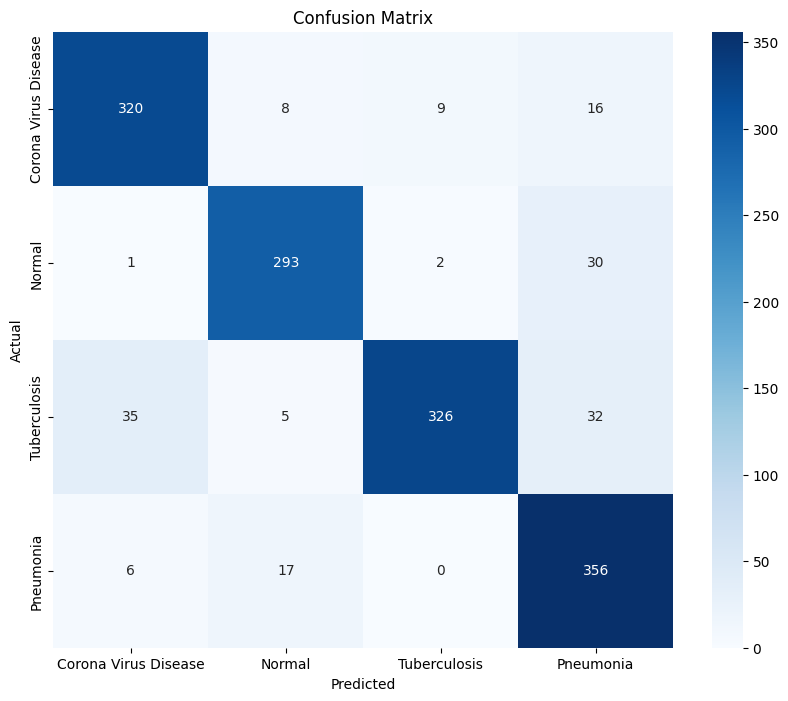

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['Corona Virus Disease', 'Normal', 'Tuberculosis', 'Pneumonia']
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

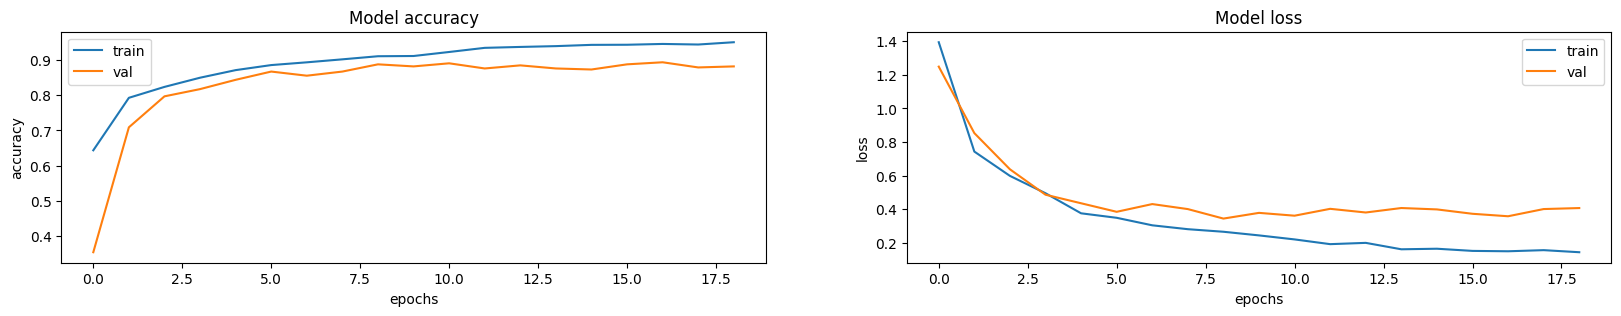

In [20]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
import matplotlib.pyplot as plt


# Create the subplots and plot the metrics as you have done
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Save the plot as an image
filename = "model_performance.png"
fig.savefig(filename, bbox_inches='tight')

plt.show()


In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from sklearn.metrics import classification_report

# Load the trained model
model = load_model('/content/lung_disease_detection_model.keras')

# Path to the single unseen image
unseen_image_path = '/content/Chest.webp'

# Verify if the file exists
if not os.path.exists(unseen_image_path):
    print(f"Error: File not found at {unseen_image_path}")

else:
    # Define image dimensions and other preprocessing parameters
    img_height = 150
    img_width = 150

    # Load and preprocess the unseen image
    img = load_img(unseen_image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions on the unseen image
    y_pred_unseen = model.predict(img_array)
    y_pred_class = np.argmax(y_pred_unseen, axis=1)[0]

    # Define class names (replace these with your actual class names)
    class_names = [ 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Pneumonia']

    # Print the predicted class for the image
    print(f'Filename: {unseen_image_path} - Predicted Class: {class_names[y_pred_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Filename: /content/Chest.webp - Predicted Class: Corona Virus Disease
